<a href="https://colab.research.google.com/github/min02yam/Projects/blob/master/Real-estate/%EB%AA%A8%EB%8D%B8%EB%A7%81_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 목차

    1. 데이터 로드
    2. 결측치 확인 및 제거
    3. 이상치 확인 및 제거
    4. 변수선택
    5. 데이터 정규화
    6. 모델 생성 및 학습
     6-1 Regression :LASSO, Ridge
     6-2. RandomForestRegressor
    7. Grid Search
    8. Cross Validation
- 스케일링 ref. https://databreak.netlify.app/2019-05-02-Normalization_vs_Standardization-Quantitative%20analysis/
- 문자열 포맷 ref.https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=pgh7092&logNo=221103140268
- 그리드서치 ref. https://statkclee.github.io/model/model-python-xgboost-hyper.html

# 데이터 로드

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import pickle
with open( "월별부동산데이터", "rb" ) as file:
    df = pickle.load(file)

## 1) Train, Test 분할

In [ ]:
train = df[df.index < pd.to_datetime('2019-12-31')]
test = df[df.index > pd.to_datetime('2019-12-31')]

In [ ]:
print(train.shape)
print(test.shape)

(120, 11)
(18, 11)


- 총 138의 data raw
- train: 120 행(12개월 x 10년), 
- test: 18 행(1년 6개월)
- 피처 10개, 타겟 1개 --> 총 11개

In [ ]:
# train
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2010-01-01 to 2019-12-01
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   강남구_매매가        120 non-null    float64
 1   강남구_전세가        120 non-null    float64
 2   서울_인허가물량       120 non-null    float64
 3   서울_미분양물량       120 non-null    float64
 4   NASDAQCOM      120 non-null    float64
 5   CSUSHPISA      120 non-null    float64
 6   HSN1F          120 non-null    float64
 7   INTDSRUSM193N  120 non-null    float64
 8   USSTHPI        120 non-null    float64
 9   M2             120 non-null    float64
 10  ICSA           120 non-null    float64
dtypes: float64(11)
memory usage: 11.2 KB


# 결측치 확인 및 제거

In [ ]:
train.isnull().sum()

강남구_매매가          0
강남구_전세가          0
서울_인허가물량         0
서울_미분양물량         0
NASDAQCOM        0
CSUSHPISA        0
HSN1F            0
INTDSRUSM193N    0
USSTHPI          0
M2               0
ICSA             0
dtype: int64

<AxesSubplot:>

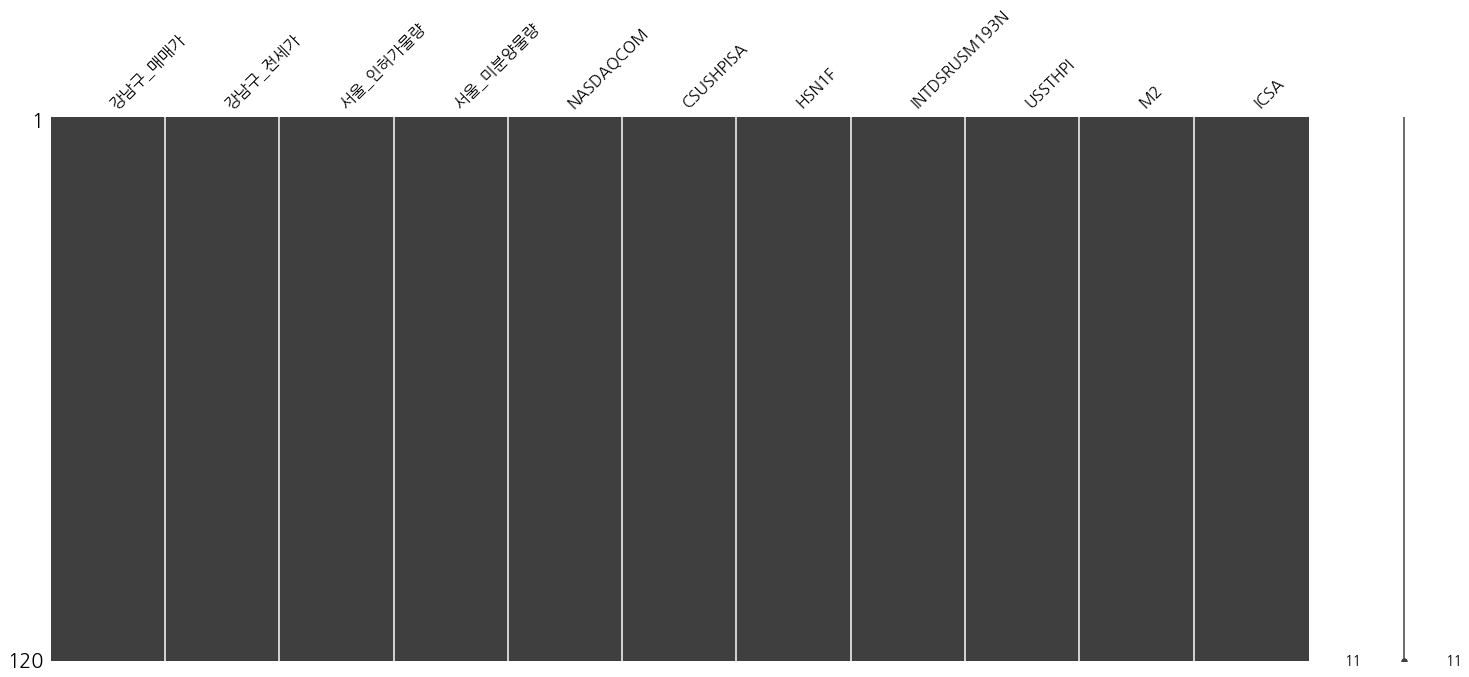

In [ ]:
# !pip install missingno
import matplotlib.pyplot as plt
import missingno as msno

%matplotlib inline

plt.rc('font', family = 'NanumGothic')
msno.matrix(train)

# 이상치 확인 및 제거

KDE : Kernel Density Estimation 커널 밀도 추정
밀도 추정은 x의 확률밀도함수(pdf, probability density function)를 추정

밀도추정(density estimation) 방법은 크게 parametric 방법과 non-parametric 방법으로 구분
Parametric 밀도추정은 미리 pdf(probability density function)에 대한 모델을 정해놓고 데이터들로부터 모델의 파라미터만 추정

Non-parametric 밀도추정의 가장 간단한 형태가 바로 히스토그램(histogram). 히스토그램은 bin이 나눠져 있는 형태로 연속적이지 않음
커널함수는 원점을 중심으로 대칭이면서 적분값이 1인 non-negative 함수로 정의되며 가우시언(Gaussian)

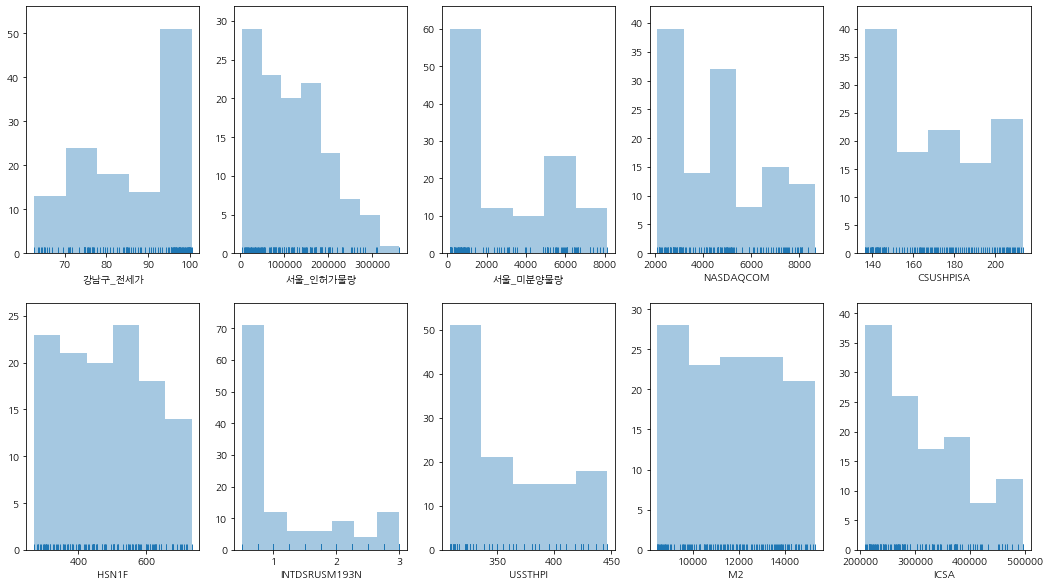

In [ ]:
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

# 컬럼별 Data 분포 히스토그램

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (18, 10))
num = 0
ax = ax.flatten()
for col in list(train.columns[1:]):
    sns.distplot(train[col], ax = ax[num], kde = False, rug = True) # kde True는 확률 밀도 곡선이 나오고, rug는 하부에 밀도 분포표시
    num += 1    
plt.show()

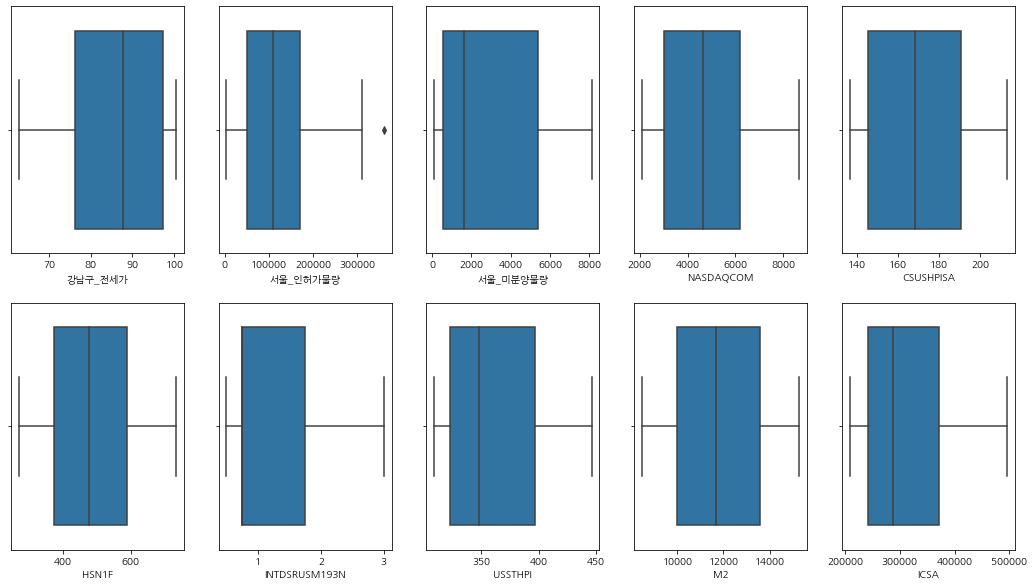

In [ ]:
#컬럼별 Data 분포 Boxplot
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (18, 10))
num = 0
ax = ax.flatten()
for col in list(train.columns[1:]):
    sns.boxplot(train[col], ax = ax[num])
    num += 1    
plt.show()

- 서울 인허가 물량에  이상치가 존재

## 이상치 제거

In [ ]:
##
#quartile_1 = train.quantile(0.25)
#quartile_3 = train.quantile(0.75)

#IQR = quartile_3 - quartile_1
#condition = (train < (quartile_1 - 1.5 * IQR)) | (train > (quartile_3 + 1.5 * IQR))
#condition = condition.any(axis=1)
#train = train[condition]
#print(train.shape)
##

'\nquartile_1 = train.quantile(0.25)\nquartile_3 = train.quantile(0.75)\n\nIQR = quartile_3 - quartile_1\ncondition = (train < (quartile_1 - 1.5 * IQR)) | (train > (quartile_3 + 1.5 * IQR))\ncondition = condition.any(axis=1)\ntrain = train[condition]\nprint(train.shape)\n'

# 4. 변수선택

## 1) 상관관계

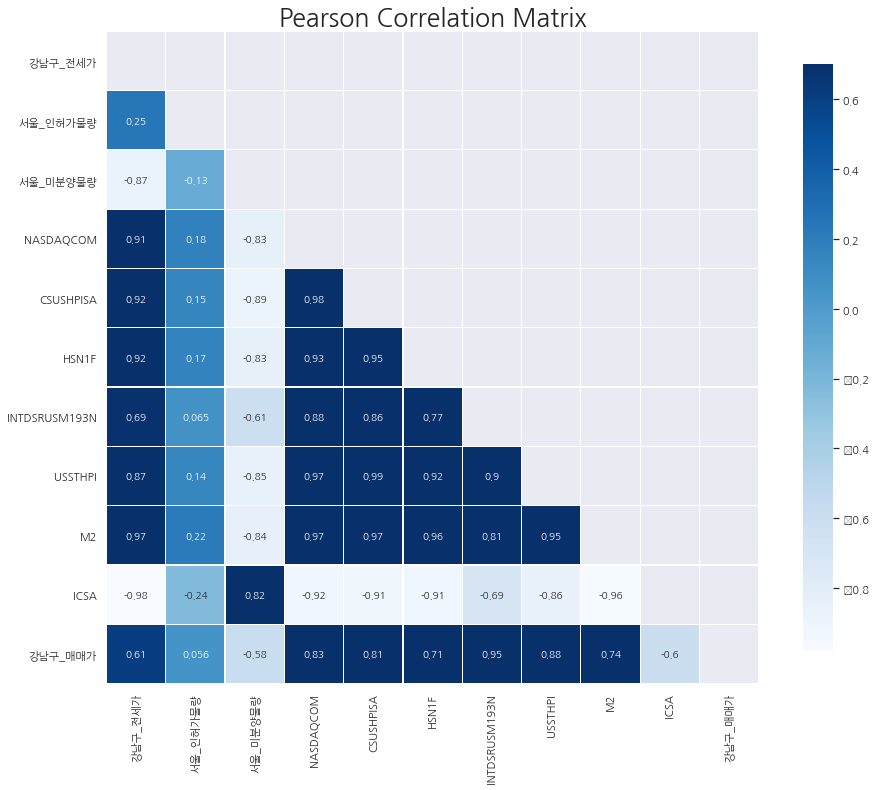

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(font="NanumGothic")

import warnings
warnings.filterwarnings(action='ignore')

features = ['강남구_전세가', '서울_인허가물량', '서울_미분양물량', 'NASDAQCOM', 
                 'CSUSHPISA', 'HSN1F', 'INTDSRUSM193N', 'USSTHPI', 'M2', 'ICSA','강남구_매매가']


# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(train[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(train[features].corr(),
            linewidths=0.25,# 경계면 선구분 cf. 실선(0.5)으로 구분하기
            vmax=0.7, # 컬러바 범위 : 최소값 미지정 최대값 0.7 
            square=True,
            cmap="Blues", #히트맵 색깔. blue, green #"BuGn_r" to reverse # Blues # BuGn
            linecolor='w',# 라인 색은 흰색(white)
            
            annot=True,            # 실제 값을 표시한다
            annot_kws={"size":10},  # 실제값 폰트 사이즈
            mask=mask,             # 위에서 설정한 마스크 부분(가릴부분) 지정한다
            cbar_kws={"shrink": .9}); # 오른쪽 컬러바 크기 줄이기 90% 크기

* 0.1(자체 판단)이하 변수를 제거
    - 서울 인허가 물량의 상관계수가 0.056으로 매우 낮지만, 2~3년 shift를 해서 정리
    - 인허가 물량---> 공급 직접적인 요소,,,

In [ ]:
co = train.corrwith(train['강남구_매매가'])

print(co.sort_values(ascending=False))
co_abs = abs(co)

강남구_매매가          1.000000
INTDSRUSM193N    0.950789
USSTHPI          0.882041
NASDAQCOM        0.825934
CSUSHPISA        0.806263
M2               0.737103
HSN1F            0.710513
강남구_전세가          0.605002
서울_인허가물량         0.055719
서울_미분양물량        -0.579675
ICSA            -0.597001
dtype: float64


In [ ]:
# 상관계수의 절대값
co_sort = co_abs.sort_values(ascending=False)
co_sort = co_sort[co_sort>0.1]
co_sort.to_frame().index

# 상관관계 낮은 변수를 제거, 새로운 변수 생성
new_features = co_sort.to_frame().index
new_features

Index(['강남구_매매가', 'INTDSRUSM193N', 'USSTHPI', 'NASDAQCOM', 'CSUSHPISA', 'M2',
       'HSN1F', '강남구_전세가', 'ICSA', '서울_미분양물량'],
      dtype='object')

In [ ]:
print(len(features))
print(len(new_features))

print('제거된 변수의 갯수 :{}개'.format(len(features) - len(new_features)))

11
10
제거된 변수의 갯수 :1개


서울_인허가 물량 이 제거 되었습니다.

## Data Set 정리
이상치, 변수선택을 고려

In [ ]:
# # 데이터 불러오기
features = ['강남구_전세가', '서울_인허가물량', '서울_미분양물량', 'NASDAQCOM', 
                 'CSUSHPISA', 'HSN1F', 'INTDSRUSM193N', 'USSTHPI', 'M2', 'ICSA']

target = '강남구_매매가'

X = train[features]
y = train[target]

In [ ]:
X

,강남구_전세가,서울_인허가물량,서울_미분양물량,NASDAQCOM,CSUSHPISA,HSN1F,INTDSRUSM193N,USSTHPI,M2,ICSA
2010-01-01,62.645190,3819.0,2508.0,2171.200,147.395,345.0,0.50,326.35,8481.3,496000.0
2010-02-01,63.511187,7527.0,4182.0,2171.200,145.630,336.0,0.75,326.35,8481.3,496000.0
2010-03-01,63.843571,21624.0,3414.0,2273.570,145.858,381.0,0.75,326.35,8507.9,488000.0
2010-04-01,64.321810,30459.0,3954.0,2402.580,146.401,422.0,0.75,323.41,8510.3,459000.0
2010-05-01,64.583027,37710.0,5094.0,2461.190,146.392,280.0,0.75,323.41,8550.0,451000.0
...,...,...,...,...,...,...,...,...,...,...
2019-08-01,97.443658,140742.0,1182.0,8111.121,210.396,677.0,2.75,442.23,14915.4,216000.0
2019-09-01,97.620698,148727.0,1116.0,7962.883,211.053,706.0,2.50,442.23,14950.7,218000.0
2019-10-01,98.456938,157780.0,1068.0,7908.684,211.653,703.0,2.25,446.22,15098.0,217000.0
2019-11-01,98.818967,172001.0,996.0,8386.398,212.457,700.0,2.25,446.22,15200.4,216000.0


# 데이터 정규화(Data normalization)

- MinMax: 상한과 하한이 비교적 명확하고, 상한과 하한 사이에 값들이 어느정도 일정하게 분포하는 경우에 사용 
- Standardization: 데이터가 정규 분포를 따를 때 사용하면 효과적
- y변수는 normalization을 하는 것이 일반적임, 왜냐하면 normalization은 특정 x 변수가 y 예측에 큰 영향을 끼치는 것을 방지하거나, gradient descent를 이용하는 학습을 좀 더 빠르게 하기 위해서이기 때문

In [ ]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split                                                     

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.1, random_state=1)

# 피처 스케일링
scaler = preprocessing.MinMaxScaler()

train_X_norm = scaler.fit_transform(train_X)
valid_X_norm = scaler.fit_transform(valid_X)

# 모델생성 및 학습

## 6-1. Linear Regression

In [ ]:
# 회귀모델 학습
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_X_norm, train_y)

# 예측값 생성
predicts = lr.predict(valid_X_norm)

# 오차계산
from sklearn.metrics import mean_absolute_error

valid_MAE = mean_absolute_error(valid_y, predicts)
print(f"valid MAE: {valid_MAE:.3f}")

valid MAE: 3.306


- MAE 값 매우 낮음

In [ ]:
lr_coef_df = pd.DataFrame(lr.coef_, index=X.columns, columns=["lr_coef"])
lr_coef_df.sort_values(ascending=False, by='lr_coef')

,lr_coef
USSTHPI,48.121635
NASDAQCOM,16.999539
INTDSRUSM193N,14.791758
강남구_전세가,10.924932
ICSA,6.835567
서울_미분양물량,3.840984
HSN1F,0.674838
서울_인허가물량,-0.208089
M2,-23.416522
CSUSHPISA,-30.802263


In [ ]:
# 모델 정확도 계산
accuracy = lr.score(valid_X_norm, valid_y)
print("예측모델 정확도는 {:.2f}% 입니다.".format(float(accuracy*100)))

예측모델 정확도는 85.39% 입니다.


In [ ]:
accuracy

0.8538857162106568

### 실제값과 모델이 예측한 값을 비교

Text(0.5, 1.0, '실제값 vs 예측값 : $Y$ vs $\\hat{Y}$')

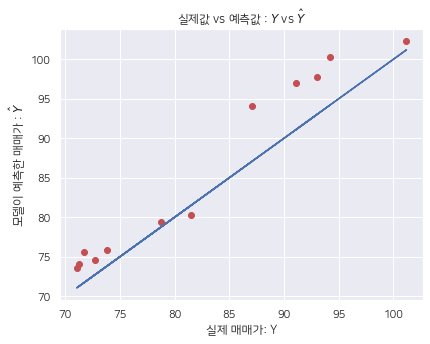

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# 한글폰트
import matplotlib.font_manager as fm
path = 'C:\\Windows\\Fonts\\NanumSquareRoundB.ttf'
font_name = fm.FontProperties(fname=path).get_name()
plt.rc('font', family=font_name)

# 사이즈
plt.figure(figsize=(6.5, 5))

Y_pred = lr.predict(valid_X_norm)

plt.scatter(valid_y, Y_pred, color='r')
plt.plot(valid_y, valid_y)

plt.xlabel("실제 매매가: Y")
plt.ylabel("모델이 예측한 매매가 : $\hat{Y}$")
plt.title("실제값 vs 예측값 : $Y$ vs $\hat{Y}$")

In [ ]:
from sklearn.metrics import mean_absolute_error

train_MAE = mean_absolute_error(train_y, lr.predict(train_X_norm))
valid_MAE = mean_absolute_error(valid_y, lr.predict(valid_X_norm))

print(f"train MAE: {train_MAE:.3f}")
print(f"valid MAE: {valid_MAE:.3f}")

train MAE: 1.340
valid MAE: 3.306


## LR vs. Ridge vs. Lasso

### 1) Lasso regression

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
lasso = Lasso(alpha=1)
lasso.fit(train_X_norm, train_y)

train_rmse = metrics.mean_absolute_error(train_y, lasso.predict(train_X_norm))
valid_rmse = metrics.mean_absolute_error(valid_y, lasso.predict(valid_X_norm))

print(f"train: {train_rmse:.3f}")
print(f"test: {valid_rmse:.3f}")

train: 3.180
test: 2.684


### 2) Ridge regression

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
ridge = Ridge(alpha=1)
ridge.fit(train_X_norm, train_y)

train_MAE = metrics.mean_absolute_error(train_y, ridge.predict(train_X_norm))
valid_MAE = metrics.mean_absolute_error(valid_y, ridge.predict(valid_X_norm))

print(f"train: {train_MAE:.3f}")
print(f"test: {valid_MAE:.3f}")

train: 1.985
test: 2.949


* 딥러닝 모델 학습 시 몇 개의 노드를 제외하고 학습하는 방법
* 랜덤하게 사용하지 않을 노드를 결정
* 계산이 줄어드는 만큼 variance가 줄어들어 overfitting을 줄일 수 있음.

## 6-3. Random Forest

In [ ]:
import pandas as pd
import numpy as np
import random

# 전처리
from sklearn import datasets
train = df[df.index < pd.to_datetime('2019-12-31')]
test = df[df.index > pd.to_datetime('2019-12-31')]


# 2. 변수선택
features = ['강남구_전세가', '서울_인허가물량', '서울_미분양물량', 'NASDAQCOM', 
                 'CSUSHPISA', 'HSN1F', 'INTDSRUSM193N', 'USSTHPI', 'M2', 'ICSA']
target = '강남구_매매가'
            
X = train[features]
y = train[target]

# 시드
SEED = 1
random.seed(SEED)
np.random.seed(SEED)

# 데이터 전처리
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
                                                      
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=1)

# 피처 스케일링
scaler = preprocessing.MinMaxScaler()

train_X_norm = scaler.fit_transform(train_X)
valid_X_norm = scaler.fit_transform(valid_X)

#모델링
RF = RandomForestRegressor()    
RF.fit(train_X_norm, train_y)

# 예측값 생성
predicts = RF.predict(valid_X_norm)

# 오차계산
from sklearn.metrics import mean_absolute_error

valid_MAE = mean_absolute_error(valid_y, predicts)
print(f"valid MAE: {valid_MAE:.3f}")

test_X_norm = scaler.transform(test[features])
final_predict = RF.predict(test_X_norm)

valid MAE: 0.863


# 7. Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 6, 9, 12],
    'min_samples_split': [0.01, 0.05, 0.1],
    'max_features': ['auto', 'sqrt'],
}

RF = RandomForestRegressor()

from sklearn.model_selection import KFold

kf = KFold(random_state=30,
           n_splits=10,
           shuffle=True,
          )

grid_search = GridSearchCV(estimator=RF, 
                           param_grid=param_grid, 
                           cv=kf, 
                           n_jobs=-1, 
                           verbose=2
                          )

#피팅
grid_search.fit(train_X_norm, train_y)

grid_search.best_params_

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   48.2s finished


{'max_depth': 9,
 'max_features': 'auto',
 'min_samples_split': 0.01,
 'n_estimators': 150}

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
import pandas as pd
import numpy as np
import random

# 데이터 전처리
from sklearn import datasets
train = df[df.index < pd.to_datetime('2019-12-31')]
test = df[df.index > pd.to_datetime('2019-12-31')]


# 2. 변수선택
features = ['강남구_전세가', '서울_인허가물량', '서울_미분양물량', 'NASDAQCOM', 
                 'CSUSHPISA', 'HSN1F', 'INTDSRUSM193N', 'USSTHPI', 'M2', 'ICSA']
target = '강남구_매매가'
X = train[features]
y = train[target]

#시드 고정
SEED = 1
random.seed(SEED)
np.random.seed(SEED)

# 트렝니 테스트 분할
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
                                                      
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=1)

# 피처 스케일링
scaler = preprocessing.MinMaxScaler()

train_X_norm = scaler.fit_transform(train_X)
valid_X_norm = scaler.fit_transform(valid_X)
test_X_norm = scaler.transform(test[features])


# GridSearch
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300, 350, 400],
    'max_depth': [None, 6, 12, 24, 32, 64],
    'min_samples_split': [0.01, 0.05, 0.1],
    'max_features': ['auto', 'sqrt'],
}

RF = RandomForestRegressor()

# Cross Validation
from sklearn.model_selection import KFold
kf = KFold(random_state=30,
           n_splits=10,
           shuffle=True,
          )


# define grid_search
grid_search = GridSearchCV(estimator=RF, 
                           param_grid=param_grid, 
                           cv=kf, 
                           n_jobs=-1, 
                           verbose=2
                          )

grid_search.fit(train_X_norm, train_y)
grid_search.best_params_

# 베스트 모델 학습
best_model.fit(train_X_norm, train_y)

# 예측값 생성
predicts = best_model.predict(valid_X_norm)

# 오차계산
from sklearn.metrics import mean_absolute_error

valid_MAE = mean_absolute_error(valid_y, predicts)
print(f"valid MAE: {valid_MAE:.3f}")

# test_X_norm = scaler.transform(test[features])
final_predict = best_model.predict(test_X_norm)


Fitting 10 folds for each of 252 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:  3.2min finished


valid MAE: 0.855


In [ ]:
print(grid_search.best_params_)

{'max_depth': 6, 'max_features': 'auto', 'min_samples_split': 0.01, 'n_estimators': 100}
